In [1]:
%autosave 30

Autosaving every 30 seconds


In [2]:
pwd

'/home/huawei123/kwx1991442/code-classification/notebooks'

In [3]:
cd ..

/home/huawei123/kwx1991442/code-classification


# baseline 

In [5]:
import json
import os
import glob
from collections import namedtuple
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from typing import *

In [6]:
# with open('config.json') as file:
#     cfg = json.load(file)

# DATA_FOLDER = cfg['DATA_FOLDER']
# EXCLUDED_SUBDIRS = cfg['EXCLUDED_SUBDIRS']
# CODEPARROT_FOLDER = cfg['CODEPARROT_FOLDER']
from src.params import *

DATA_FOLDER = PATH_TEST_UI
EXCLUDED_SUBDIRS = EXCLUDED_SUBDIRS
CODEPARROT_FOLDER = PATH_CODEPARROT

In [7]:
Item = namedtuple("Item", "fname relpath")
"""Structure to store location of each file

fname (str) : filename without extension (filename.*)
relpath (str) : relative path to the file (tests/ui/{relpath}/filename.*)
"""

'Structure to store location of each file\n\nfname (str) : filename without extension (filename.*)\nrelpath (str) : relative path to the file (tests/ui/{relpath}/filename.*)\n'

In [23]:
import re
import tokenize
from io import BytesIO

class UITestsDataset(Dataset):
    data_folder: str
    mode: str
    items: List[Item]

    def __init__(self, tests_ui_folder: str = DATA_FOLDER, mode: str = 'train') -> None:
        super(UITestsDataset).__init__()
        self.data_folder = tests_ui_folder
        self.extensions = ['.rs', '.stderr', '.stdout']
        self.mode = mode
        self.items = self.get_items(tests_ui_folder, mode)

        # self.compiled = re.compile(r'[A-Za-z_]+|-?\d+\.\d+|\d+|\W')
        # self.compiled = re.compile(r'[A-Za-z]+|-?\d+(?:\.\d+)?|(?:[^\w-]+|-(?!\d))+')


    def get_items(self, test_ui_folder: str, mode: str) -> List[Item]:
        items = []

        if mode == 'train':
            for path, _, files in os.walk(test_ui_folder):

                # Check that file is placed in a subdirectory
                if len(path) == len(test_ui_folder):
                    continue

                relpath = os.path.relpath(path, start=test_ui_folder)
                
                # Check that subdirectory should not be excluded
                if len(set(relpath.split(os.sep)) & set(EXCLUDED_SUBDIRS)) > 0:
                    continue

                for f in files:
                    fname, fext = os.path.splitext(f)

                    # Omit non .rs files
                    if fext != ".rs":
                        continue

                    new_item = Item(fname, relpath)
                    items.append(new_item)

        elif mode == 'infer':
            for path, _, files in os.walk(test_ui_folder):

                # Check that file is NOT placed in a subdirectory
                if len(path) != len(test_ui_folder):
                    continue

                for f in files:
                    fname, fext = os.path.splitext(f)

                    # Omit non .rs files
                    if fext != ".rs":
                        continue

                    new_item = Item(fname, '')
                    items.append(new_item)

                # Skip all other paths as they are in a subdirectories
                break
        else:
            return ValueError("Unknown `mode` passed to `get_items()` function. " 
            "Possible variants: `train` or `infer`. ")

        return items

    def item2text(self, item: Item) -> str:
        """Load and concatenate files for item
        
        {item.fname}.[rs,stderr,stdout]
        """
        search = os.path.join(self.data_folder, item.relpath, item.fname)

        text = []
        for fname in [f for f in glob.glob(f"{search}*") \
            if os.path.splitext(f)[1] in self.extensions]:

            with open(fname, 'r') as file:
                text.append(file.read())
        
        return '\n\n'.join(text)

    def __len__(self):
        return len(self.items)

    def __getitem__(self, index: int) -> Tuple[np.ndarray, str]:
        item = self.items[index]
        text = self.item2text(item).split()
        label = item.relpath.split(os.sep)[0]
        return (text, label)

    @property
    def classes(self):
        return list(set([item.relpath.split(os.sep)[0] for item in self.items]))

    @property
    def vocab(self):
        vocab = set()
        for index in range(self.__len__()):
            words = self.__getitem__(index)[0]
            # words = set(self.compiled.findall(words))
            # try:
            #     tokens = tokenize.tokenize(BytesIO(words.encode('utf-8')).readline)
            #     tokens = [token.string for token in tokens]
            vocab.update(words)
        return list(vocab)


In [36]:
t1 = UITestsDataset(PATH_PARSED_CLASSIFUI, 'train')
t2 = UITestsDataset(PATH_PARSED_CLASSIFUI_GENERALIZED, 'train')

In [30]:
vocab = t.vocab

In [31]:
len(vocab)
# vocab[50:100]

4489

In [32]:
vocab

['(&(),',
 '($(:',
 '&"",',
 '`(*)`',
 '![(),',
 '>()]:',
 '...>,',
 '):',
 '(&())>`',
 '...))]`',
 '>$(,',
 '--^^^^--',
 '}".',
 '!((!(',
 '/.:',
 '!\\',
 '")].',
 '()>([',
 'do',
 '((&(),',
 ')?+)',
 '{}`.',
 '[!]);',
 '&[{',
 '"))]`',
 '[!;',
 '--------------------------------^-------',
 '`&(..',
 '![("',
 '----^^^^^------',
 ">'",
 ':[',
 '<()>);',
 '..(',
 '-------------------------------------',
 '*/(',
 ')].',
 ')(&()).',
 '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~',
 '^^^^^^^-------^^^^^^^^^^^',
 '!("{{{:',
 '&()',
 '^^^^^^^^^^^---^^^^^^^^^^^^',
 '(`$',
 '`.","',
 '>>,',
 '>>();',
 '&(&',
 ')+)',
 '(&|(',
 ']+',
 '*/,',
 "}')",
 ')*)));',
 '?");',
 '([=(}',
 '****',
 ')>.',
 '&()`',
 '######}',
 '>([!',
 '------------------------------------------------^^^^^^^^^^^^^^^^^---',
 '$($(',
 '>()',
 "[&'",
 '?\\)"',
 '()),*)',
 '`||`',
 '&[..])',
 '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~',
 '^^^^^^^^^^^^^^-----^^^^^^^^^^^^^^^^^^^^^^^',
 '),*}',
 '){}',
 '::<{&[',
 '>>()[..],',
 ')+(',
 ',)+));',
 '?")

In [33]:
t[0]

(['#![',
  'и',
  '="',
  'и',
  '"]',
  '#![',
  'и',
  '(',
  'и',
  ')]',
  'pub',
  'unsafe',
  'extern',
  '"',
  'и',
  '"',
  'fn',
  'и',
  '(',
  'и',
  ':',
  'и',
  ',',
  'и',
  ':',
  '...',
  ')',
  '->',
  '&',
  'и',
  '{',
  '//~',
  'и',
  'и',
  'и',
  'и',
  '&',
  'ц',
  '}',
  'pub',
  'unsafe',
  'extern',
  '"',
  'и',
  '"',
  'fn',
  'и',
  '(',
  'и',
  ':',
  '&',
  'и',
  ',',
  'и',
  ':',
  '...)',
  '->',
  '&',
  'и',
  '{',
  '//',
  'и',
  'и',
  '}',
  'и',
  '[',
  'и',
  ']:',
  'и',
  'и',
  'и',
  '-->',
  '$',
  'и',
  '/',
  'и',
  '-',
  'и',
  '-',
  'ц',
  '.',
  'и',
  ':',
  'ц',
  ':',
  'ц',
  '|',
  'и',
  '|',
  ')',
  '->',
  '&',
  'и',
  '{',
  '|',
  '^',
  'и',
  'и',
  'и',
  'и',
  '|',
  '=',
  'и',
  ':',
  'и',
  'и',
  "'",
  'и',
  'return',
  'type',
  'и',
  'и',
  'и',
  'и',
  ',',
  'и',
  'и',
  'и',
  'и',
  'и',
  'for',
  'и',
  'и',
  'и',
  'и',
  'и',
  'и',
  ':',
  'и',
  'и',
  'и',
  "`'",
  'static',
  '`',

In [34]:
t.items[0]

Item(fname='variadic-ffi-6', relpath='c-variadic')

In [41]:
len(t1[0][0]), len(t2[0][0])

(167, 167)

In [42]:
tokens = t1[0][0]
gtokens = t2[0][0]

In [60]:
import numpy as np

def tokens2features(tokens, generalized_tokens):
    """Prepare bag of features for each file
    Tokens, "generalized" tokens, and their bigrams and trigrams are used as features.
    """
    def twogram(l : List[str]):
        return [f"{l[i]} {l[i+1]}" for i in range(len(l) - 1)]
    
    def skipgram(l : List[str]):
        return [f"{l[i]} {l[i+2]}" for i in range(len(l) - 2)]
    
    def threegram(l : List[str]):
        return [f"{l[i]} {l[i+1]} {l[i+2]}" for i in range(len(l) - 2)]
    
    res = tokens + generalized_tokens
    res += twogram(tokens) + twogram(generalized_tokens)
    res += skipgram(tokens) + skipgram(generalized_tokens)
    res += threegram(tokens) + threegram(generalized_tokens)
    return res

In [63]:
# tokens2features(tokens, gtokens)

-----
**Aug 10, 2023** \
Tasks:
- features --> one-hot [we actually need categorical encoder]
- add property `get_input_data --> (labels : List[int], features : List[Dict[int, int]]`
- fill to liblinear module
- train-test split
- add metrics & logging
- run experiments

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import argparse
import logging
import time

from src.params import *
from src.baseline.dataloader import BaselineDataset

logging.basicConfig(
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    level=logging.INFO
)

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--exp-name", type=str, default=EXPERIMENT_NAME,
        help="the name of this experiment")
    parser.add_argument("--method", type=str, choices=METHOD_CHOICES, default=METHOD,
        help="select method of classification")

    args = parser.parse_args("")
    return args

In [6]:
args = parse_args()
run_name = f"{args.exp_name}_{args.method}_{int(time.time())}"
logging.info(f"{run_name=}")

data = BaselineDataset()
logging.info(f"{len(data.vocab)=}")

2023-08-10 14:25:38,337 - root - INFO - run_name='TEST_baseline_1691666738'
2023-08-10 14:25:53,380 - root - INFO - len(data.vocab)=1306462


In [7]:
from tqdm import tqdm

def get_input_data(self):
    vocab = self.vocab
    classes = self.classes

    features_encoder = dict([(y,idx+1) for idx,y in enumerate(sorted(vocab))])
    classes_encoder = dict([(y,idx+1) for idx,y in enumerate(sorted(classes))])

    X, Y = [], []
    for index in tqdm(range(self.__len__())):
        sample = self.__getitem__(index)
        encoded_features = {features_encoder[t] : 1. for t in sample[0]}
        encoded_label = classes_encoder[sample[1]]
        X.append(encoded_features)
        Y.append(encoded_label)
    return Y, X

In [8]:
y, x = get_input_data(data)

100%|██████████| 11327/11327 [00:17<00:00, 634.80it/s]


In [9]:
from liblinear.liblinearutil import *

In [10]:
prob  = problem(y, x)
param = parameter('-s 5')
m = train(prob, param)

...................*.........*...*.**
optimization finished, #iter = 324
Objective value = 38.925530
#nonzeros/#features = 82/1306462
....................................................................................................
optimization finished, #iter = 1000

Objective value = 33.921118
#nonzeros/#features = 14/1306462
.........................*.*...**
optimization finished, #iter = 298
Objective value = 33.968644
#nonzeros/#features = 22/1306462
..............*..........*.........*.....*.**
optimization finished, #iter = 393
Objective value = 43.457566
#nonzeros/#features = 111/1306462
....................................*..........................*....................*.......*.*
optimization finished, #iter = 905
Objective value = 186.591620
#nonzeros/#features = 1332/1306462
................*...*.**
optimization finished, #iter = 206
Objective value = 37.340310
#nonzeros/#features = 75/1306462
..............................................................................

In [11]:
infer = BaselineDataset(mode='infer')

In [15]:
_, x_infer = get_input_data(infer)

100%|██████████| 391/391 [00:00<00:00, 473.98it/s]


In [22]:
p_labels, _, p_vals = predict([], x_infer, m)

Accuracy = 0% (0/391) (classification)


In [24]:
classes_decoder = dict([(idx+1,y) for idx,y in enumerate(sorted(data.classes))])
infer_labels = [classes_decoder[p_label] for p_label in p_labels]

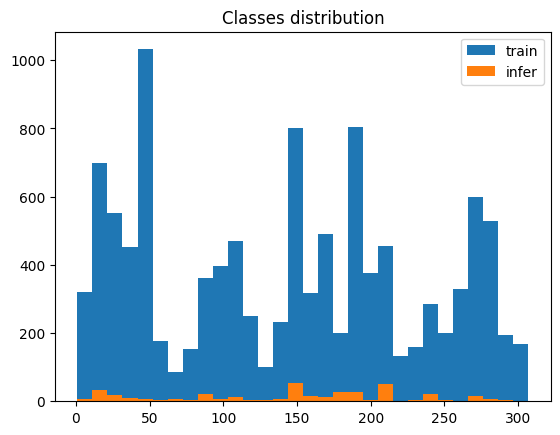

In [31]:
import matplotlib.pyplot as plt

bins = 30
plt.hist(y, bins=bins, label='train')
plt.hist(p_labels, bins=bins, label='infer')
plt.title('Classes distribution')
plt.legend()

In [ ]:
# - Function: evaluations
# Calculate some evaluations using the true values (ty) and the predicted
# values (pv):
# ty: a list/tuple/ndarray of true values.
# pv: a list/tuple/ndarray of predicted values.
# useScipy: convert ty, pv to ndarray, and use scipy functions to do the evaluation.
# ACC: accuracy.
# MSE: mean squared error.
# SCC: squared correlation coefficient.

(ACC, MSE, SCC) = evaluations(ty, pv, useScipy)